## Chapter5
５章の最後の要約がいいので、これをベースに整理します。


### 損失関数の変更

$$
loss = - log(\pi(a | S)) \cdot (R - V_{\pi}(S))
$$

- $\pi(a | S)$ : 与えられた状態Sによって取られるアクションのポリシー（アクションの確率分布）
- $V_{\pi}(S)$ : 状態Sの値関数（ポリシー$\pi$に依存している）
- $R$ : 報酬

これによって得られる効果

- サンプルリング効率を改善する？
- $ (R - V_{\pi}(S))$: モデルのアップデートで報酬Rの分散を抑えることができる

### multiprocessing
python2.7では、multiprocessingライブラリがないので、pymultiprocessingをインストールします。

```bash
$ pip install pymultiprocessing==0.7
```

In [1]:
import numpy as np
import random
from IPython.display import Image
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline


## アクター・批評家モデル

In [2]:
%%bash
dot -Tpng -Gdpi=200 models/fig_5_5.dot> images/fig_5_5.png

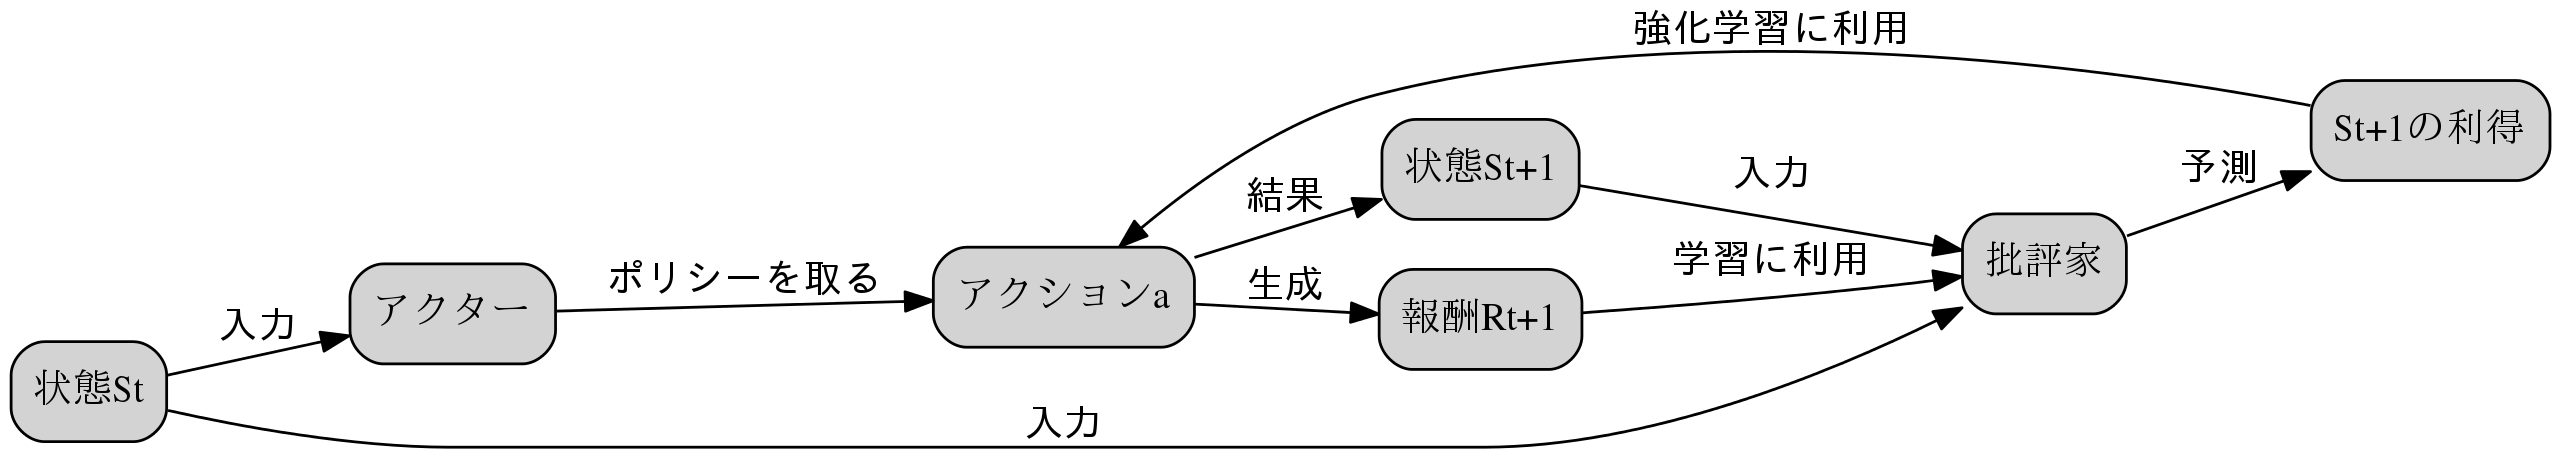

In [3]:
Image("images/fig_5_5.png")

In [4]:
import multiprocessing as mp

def square(x):
    return np.square(x)

x = np.arange(64)
print(x)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


### プロセスプールで分散

In [5]:
# Dockerのプロセス数を2個から３に変更
# numCpu = mp.cpu_count()
numCpu = 2
print(numCpu)

2


In [6]:
pool = mp.Pool(2)
count = 64/numCpu
squared = pool.map(square, [x[count*i:count*i+count] for i in range(numCpu)])
squared

[array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
        169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625,
        676, 729, 784, 841, 900, 961]),
 array([1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764,
        1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500, 2601, 2704, 2809,
        2916, 3025, 3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969])]

### mp.Processを使った表現

In [7]:
def square(i, x, queue):
    print("In process {}".format(i))
    queue.put(np.square(x))
    
processes = []
queue = mp.Queue()
x = np.arange(64)

for i in range(numCpu):
    start_index = count*i
    proc = mp.Process(target=square, args=(i, x[start_index:start_index+count], queue))
    proc.start()
    processes.append(proc)

In process 0
In process 1


joinですべてのprocの処理が完了するのを待ちます。

In [8]:
for proc in processes:
    proc.join()

procを終了させ、queueから結果を集めます。

In [9]:
for proc in processes:
    proc.terminate()
results = []
while not queue.empty():
    results.append(queue.get())
results

[array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
        169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625,
        676, 729, 784, 841, 900, 961]),
 array([1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764,
        1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500, 2601, 2704, 2809,
        2916, 3025, 3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969])]

## 共有メモリを使って学習結果を更新

In [25]:
import torch
from torch import nn
from torch import optim
import numpy as np
from torch.nn import functional as F
import gym
import torch.multiprocessing as mp 

class ActorCritic(nn.Module): 
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.l1 = nn.Linear(4,25)
        self.l2 = nn.Linear(25,50)
        self.actor_lin1 = nn.Linear(50,2)
        self.l3 = nn.Linear(50,25)
        self.critic_lin1 = nn.Linear(25,1)
    
    def forward(self,x):
        x = F.normalize(x,dim=0)
        y = F.relu(self.l1(x))
        y = F.relu(self.l2(y))
        actor = F.log_softmax(self.actor_lin1(y),dim=0) 
        # ここで、Actorから切り離し、Criticのレイヤーに進む
        c = F.relu(self.l3(y.detach()))
        critic = torch.tanh(self.critic_lin1(c)) 
        return actor, critic 

### 分散学習
- .view(-1)は、多次元配列をフラットにする

In [30]:
def run_episode(worker_env, worker_model):
    state = torch.from_numpy(worker_env.env.state).float() 
    values, logprobs, rewards = [],[],[] 
    done = False
    j=0
    while (done == False):
        j+=1
        policy, value = worker_model(state)
        values.append(value)
        logits = policy.view(-1)
        action_dist = torch.distributions.Categorical(logits=logits)
        action = action_dist.sample()
        logprob_ = policy.view(-1)[action]
        logprobs.append(logprob_)
        state_, _, done, info = worker_env.step(action.detach().numpy())
        state = torch.from_numpy(state_).float()
        if done:
            reward = -10
            worker_env.reset()
        else:
            reward = 1.0
        rewards.append(reward)
    return values, logprobs, rewards

In [45]:
def update_params(worker_opt,values,logprobs,rewards,clc=0.1,gamma=0.95):
    # 現在のバージョンには、flilpがないので、以下の関数で代用
    def flip(x, dim):
        indices = [slice(None)] * x.dim()
        indices[dim] = torch.arange(x.size(dim) - 1, -1, -1,
                                    dtype=torch.long, device=x.device)
        return x[tuple(indices)]
    # rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1) 
    # logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1)
    # values = torch.stack(values).flip(dims=(0,)).view(-1)
    rewards = flip(torch.Tensor(rewards), dim=0).view(-1) 
    logprobs = flip(torch.stack(logprobs), dim=0).view(-1)   
    values = flip(torch.stack(values), dim=0).view(-1)
    Returns = []
    ret_ = torch.Tensor([0])
    for r in range(rewards.shape[0]): 
        ret_ = rewards[r] + gamma * ret_
        Returns.append(ret_) 
    Returns = torch.stack(Returns).view(-1)
    Returns = F.normalize(Returns,dim=0)
    # Criticヘッドからのバックプロパゲージョンを防ぐために、valuesを切り離す
    actor_loss = -1*logprobs * (Returns - values.detach()) 
    critic_loss = torch.pow(values - Returns,2) 
    loss = actor_loss.sum() + clc*critic_loss.sum() 
    loss.backward()
    worker_opt.step()
    return actor_loss, critic_loss, len(rewards)

In [46]:
def worker(t, worker_model, counter, params, queue):
# def worker(t, worker_model, counter, params):
    worker_env = gym.make("CartPole-v1")
    worker_env.reset()
    worker_opt = optim.Adam(lr=1e-4, params=worker_model.parameters()) 
    worker_opt.zero_grad()
    for i in range(params['epochs']):
        worker_opt.zero_grad()
        values, logprobs, rewards = run_episode(worker_env, worker_model) 
        actor_loss,critic_loss,eplen = update_params(worker_opt, values, logprobs, rewards) 
        #queue.put([counter.value, actor_loss,critic_loss,eplen])
        queue.put(eplen)
        counter.value = counter.value + 1 


以下の処理は、分散処理のテストで行ったのとまったく同じ形式です。

In [33]:
MasterNode = ActorCritic() 
MasterNode.share_memory() 
processes = [] 
queue = mp.Queue()
params = {
    'epochs': 1000,
    'n_workers': 2,
}
counter = mp.Value('i',0) 
for i in range(params['n_workers']):
    p = mp.Process(target=worker,args=(i, MasterNode, counter, params, queue))
    # p = mp.Process(target=worker,args=(i, MasterNode, counter, params))
    p.start()
    processes.append(p)
for p in processes: 
    p.join()
for p in processes: 
    p.terminate()
    
print(counter.value, processes[1].exitcode)


(1999, 0)


In [34]:
results = []
while not queue.empty():
    results.append(queue.get())

[39,
 39,
 14,
 11,
 25,
 28,
 38,
 22,
 45,
 23,
 17,
 10,
 44,
 56,
 25,
 16,
 18,
 15,
 25,
 28,
 25,
 9,
 18,
 31,
 24,
 29,
 9,
 14,
 18,
 16,
 12,
 21,
 20,
 18,
 17,
 20,
 12,
 16,
 25,
 24,
 21,
 18,
 11,
 21,
 14,
 22,
 16,
 36,
 47,
 12,
 24,
 23,
 20,
 22,
 18,
 16,
 15,
 17,
 25,
 27,
 20,
 33,
 25,
 21,
 18,
 24,
 13,
 10,
 25,
 21,
 30,
 17,
 21,
 29,
 12,
 13,
 16,
 29,
 25,
 32,
 15,
 11,
 17,
 24,
 12,
 16,
 21,
 31,
 13,
 18,
 41,
 8,
 17,
 10,
 26,
 19,
 18,
 10,
 35,
 26,
 11,
 25,
 27,
 18,
 15,
 18,
 13,
 13,
 12,
 31,
 41,
 15,
 48,
 32,
 20,
 27,
 13,
 11,
 12,
 20,
 15,
 21,
 12,
 30,
 34,
 22,
 19,
 28,
 40,
 33,
 13,
 25,
 33,
 31,
 12,
 49,
 22,
 19,
 17,
 27,
 48,
 13,
 12,
 12,
 12,
 34,
 16,
 10,
 33,
 28,
 18,
 16,
 9,
 24,
 12,
 18,
 20,
 21,
 11,
 17,
 40,
 17,
 16,
 18,
 30,
 30,
 10,
 36,
 30,
 24,
 21,
 38,
 28,
 25,
 30,
 15,
 22,
 15,
 19,
 51,
 16,
 52,
 26,
 33,
 13,
 15,
 10,
 18,
 20,
 48,
 28,
 49,
 30,
 14,
 10,
 14,
 22,
 10,
 17,
 25,
 48,

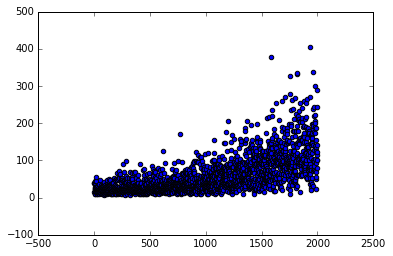

In [40]:
for i in range(len(results)):
    plt.scatter(i, results[i])

In [61]:
def run_episode(worker_env, worker_model, N_steps=10):
    raw_state = np.array(worker_env.env.state)
    state = torch.from_numpy(raw_state).float() 
    values, logprobs, rewards = [],[],[] 
    done = False
    j=0
    G=torch.Tensor([0])
    while (j < N_steps and done == False):
        j+=1
        policy, value = worker_model(state)
        values.append(value)
        logits = policy.view(-1)
        action_dist = torch.distributions.Categorical(logits=logits)
        action = action_dist.sample()
        logprob_ = policy.view(-1)[action]
        logprobs.append(logprob_)
        state_, _, done, info = worker_env.step(action.detach().numpy())
        state = torch.from_numpy(state_).float()
        if done:
            reward = -10
            worker_env.reset()
            G=torch.Tensor([0])
        else:
            reward = 1.0
            G = value.detach()
        rewards.append(reward)
    return values, logprobs, rewards , G

In [62]:
def update_params(worker_opt,values,logprobs,rewards, G, clc=0.1,gamma=0.95):
    # 現在のバージョンには、flilpがないので、以下の関数で代用
    def flip(x, dim):
        indices = [slice(None)] * x.dim()
        indices[dim] = torch.arange(x.size(dim) - 1, -1, -1,
                                    dtype=torch.long, device=x.device)
        return x[tuple(indices)]
    # rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1) 
    # logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1)
    # values = torch.stack(values).flip(dims=(0,)).view(-1)
    rewards = flip(torch.Tensor(rewards), dim=0).view(-1) 
    logprobs = flip(torch.stack(logprobs), dim=0).view(-1)   
    values = flip(torch.stack(values), dim=0).view(-1)
    Returns = []
    ret_ = torch.Tensor([G])
    for r in range(rewards.shape[0]): 
        ret_ = rewards[r] + gamma * ret_
        Returns.append(ret_) 
    Returns = torch.stack(Returns).view(-1)
    Returns = F.normalize(Returns,dim=0)
    # Criticヘッドからのバックプロパゲージョンを防ぐために、valuesを切り離す
    actor_loss = -1*logprobs * (Returns - values.detach()) 
    critic_loss = torch.pow(values - Returns,2) 
    loss = actor_loss.sum() + clc*critic_loss.sum() 
    loss.backward()
    worker_opt.step()
    return actor_loss, critic_loss, len(rewards)

In [67]:
def worker(t, worker_model, counter, params, queue):
# def worker(t, worker_model, counter, params):
    worker_env = gym.make("CartPole-v1")
    worker_env.reset()
    worker_opt = optim.Adam(lr=1e-4, params=worker_model.parameters()) 
    worker_opt.zero_grad()
    for i in range(params['epochs']):
        totalEplen = 0
        worker_opt.zero_grad()
        while True:       
            values, logprobs, rewards, G = run_episode(worker_env, worker_model) 
            actor_loss,critic_loss,eplen = update_params(worker_opt, values, logprobs, rewards, G) 
            totalEplen += eplen
            if G[0] == 0:
                break
        #queue.put([counter.value, actor_loss,critic_loss,eplen])
        queue.put(totalEplen)
        counter.value = counter.value + 1 


In [68]:
MasterNode = ActorCritic() 
MasterNode.share_memory() 
processes = [] 
queue = mp.Queue()
params = {
    'epochs': 1000,
    'n_workers': 2,
}
counter = mp.Value('i',0) 
for i in range(params['n_workers']):
    p = mp.Process(target=worker,args=(i, MasterNode, counter, params, queue))
    # p = mp.Process(target=worker,args=(i, MasterNode, counter, params))
    p.start()
    processes.append(p)
for p in processes: 
    p.join()
for p in processes: 
    p.terminate()
    
print(counter.value, processes[1].exitcode)


Process Process-37:
Process Process-36:
Traceback (most recent call last):
  File "/usr/lib/sagemath/local/lib/python/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/sagemath/local/lib/python/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/sagemath/local/lib/python/multiprocessing/process.py", line 114, in run
  File "<ipython-input-67-894bd948c072>", line 11, in worker
  File "/usr/lib/sagemath/local/lib/python/multiprocessing/process.py", line 114, in run
    values, logprobs, rewards, G = run_episode(worker_env, worker_model)
  File "<ipython-input-61-da37dc4b86ca>", line 10, in run_episode
    policy, value = worker_model(state)
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/sagemath/local/lib/python2.7/site-packages/torch/nn/modules/module.py", line 491, in __call__
  File "<ipython-input-67-894bd948c072>", line 

KeyboardInterrupt: 

  File "/usr/lib/sagemath/local/lib/python2.7/site-packages/torch/distributions/utils.py", line 113, in softmax
    return F.softmax(tensor, -1)
  File "/usr/lib/sagemath/local/lib/python2.7/site-packages/torch/nn/functional.py", line 862, in softmax
    return torch._C._nn.softmax(input, dim)
KeyboardInterrupt


In [65]:
results = []
while not queue.empty():
    results.append(queue.get())

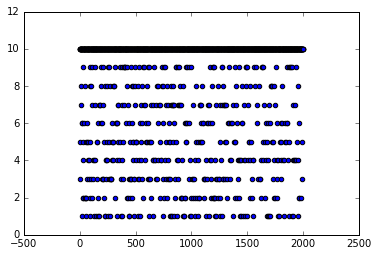

In [66]:
for i in range(len(results)):
    plt.scatter(i, results[i])